In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns
import warnings
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports

from esio import EsioData as ed
from esio import import_data
from esio import ice_plot

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
E = ed.EsioData.load()
# Directories
all_models=['uclsipn']
runType='forecast'
updateall = True

In [4]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [5]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

In [6]:
## TODO
# - Get mask
# - Get lat lon bounds 

In [7]:
var_dic = {'nav_lon':'lon','nav_lat':'lat','time_counter':'valid_time','sithic':'hi','siconc':'sic'}

In [9]:
for model in all_models:
    print('Regridding ', model, '...')
    
    data_dir = E.model[model][runType]['native']
    data_out = E.model[model][runType]['sipn_nc']
    model_grid_file = E.model[model]['grid']
    
    # Files are stored per ensembnle member, continaing 1 year of forecast
    # ex: SIPN_O2018-01A2008_1d_20180101_20181231_icemod.nc
    # Loop through each year, split up and output as init_time by month
    prefix = 'SIPN'
    all_files = sorted(glob.glob(os.path.join(data_dir, prefix+'*.nc'), recursive=True))

    print("Found ",len(all_files)," files.")
    if updateall:
        print("Updating all files...")
    else:
        print("Only updating new files")
        
    # Get number of years/init dates
    init_dates = list(set([os.path.basename(s).split('_')[3] for s in all_files]))
    print(init_dates)
    
    for c_id in init_dates:
        # Find files for current init_date
        c_files = sorted(glob.glob(os.path.join(data_dir, prefix+'*1d_'+c_id+'*.nc'), recursive=True))
        
        weights_flag = False # Flag to set up weights have been created

        # Load land/sea mask file
        if os.path.basename(model_grid_file)!='MISSING':
            ds_mask = xr.open_mfdataset(model_grid_file)
        else:
            ds_mask = None

        # Check if already imported and skip (unless updateall flag is True)
        f_out = os.path.join(data_out, c_id+'_1_Stereo.nc') # netcdf file out 
        if not updateall:
            # TODO: Test if the file is openable (not corrupted)
            if os.path.isfile(f_out):
                print("Skipping ", os.path.basename(c_id), " already imported.")
                continue # Skip, file already imported
        drop_vars = ['time_centered','axis_nbounds','time_centered_bounds','time_counter_bounds']
        ds = xr.open_mfdataset(c_files, drop_variables=drop_vars, concat_dim='ensemble', chunks={'time_counter':1})

        # Rename variables per esipn guidelines
        ds.rename(var_dic, inplace=True);

        # Shift valid time from middle of day to start of day
        ds.coords['valid_time'] = ds.valid_time - np.timedelta64(12, 'h')

        ds.coords['init_time'] = ds.valid_time.isel(valid_time=0).values

        ds.coords['fore_time'] = ds.valid_time - ds.init_time
        
        ds.swap_dims({'valid_time':'fore_time'}, inplace=True)
        
        # Only select vars we want (save space)
        ds = ds[['sic','hi']]

        #ds = ds.drop('valid_time')
        
        # Apply masks (if available)
        if ds_mask:
            print('found mask')
            # tmaskutil [1 = ocean, 0 = land]
            #ds = ds * (1 - ds_mask.land_mask.where(ds_mask.land_mask<1))
            ds = ds.where(ds_mask.tmaskutil.isel(t=0)==1)
        
        # Calculate regridding matrix
        regridder = xe.Regridder(ds, obs_grid, method, periodic=False, reuse_weights=weights_flag)
        weights_flag = True # Set true for following loops

        # Add NaNs to empty rows of matrix (forces any target cell with ANY source cells containing NaN to be NaN)
        if method=='conservative':
            regridder = import_data.add_matrix_NaNs(regridder)

        # Regrid variables
        var_list = []
        for cvar in ds.data_vars:
            var_list.append(regridder(ds[cvar]))
        ds_out = xr.merge(var_list)

        # Expand dims
        ds_out = import_data.expand_to_sipn_dims(ds_out)

        # # Save regridded to netcdf files
        f_out = os.path.join(data_out, c_id+'_Stereo.nc')
        ds_out.to_netcdf(f_out)
        
        
#         print("Writing out to multiple files...")
#         months, datasets = zip(*ds_out.groupby('valid_time.month'))
#         paths = [os.path.join(data_out, c_id+'_'+str(y)+'_Stereo.nc') for y in months]
#         xr.save_mfdataset(datasets, paths)
        
        # Memory clean up
        ds_out = None 
        ds = None
        print('Saved ', f_out)
        

Regridding  uclsipn ...
Found  10  files.
Updating all files...
['20180101']
found mask
Create weight file: nearest_s2d_292x362_304x448.nc


AttributeError: 'str' object has no attribute 'to_netcdf'

In [12]:
# Clean up
if weights_flag:
    regridder.clean_weight_file()  # clean-up

Remove file nearest_s2d_292x362_304x448.nc


# Plotting

Text(0.5,1,'Target Grid')

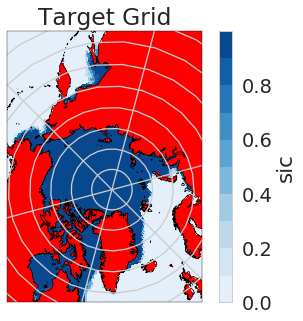

In [14]:
# sic_all = xr.open_mfdataset(f_out)
# sic_all

# # Set up plotting info
# cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
# cmap_sic.set_bad(color = 'red')

# # Plot original projection
# plt.figure(figsize=(20,10))
# ax1 = plt.axes(projection=ccrs.PlateCarree())
# ds_p = ds.sic.isel(fore_time=8).isel(ensemble=0)
# ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                  vmin=0, vmax=1,
#                                  cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)),
#                     transform=ccrs.PlateCarree());
# ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
# gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
# gl.xlabels_bottom = True
# gl.ylabels_left = True
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

# # Plot SIC on target projection
# (f, ax1) = ice_plot.polar_axis()
# ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                      transform=ccrs.PlateCarree(),
#                                      cmap=cmap_sic)
# ax1.set_title('Original Grid')

# # Plot SIC on target projection
# (f, ax1) = ice_plot.polar_axis()
# ds_p2 = sic_all.sic.isel(init_time=0).isel(fore_time=8).isel(ensemble=0)
# ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                      transform=ccrs.PlateCarree(),
#                                      cmap=cmap_sic)
# ax1.set_title('Target Grid')
